In [2]:
import cvxpy as cp
import numpy as np
# from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt 
# %matplotlib widget 

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/root/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


How to give velocity constraint

In [145]:
n = 10

# Define the variables
X = cp.Variable(n)
Y = cp.Variable(n)
Z = cp.Variable(n)

# Define the maximum velocity
V_max = 10

# Define the time step
dt = 0.1

# Define the constraint
constraint = []
for t in range(n-1):
    diff_squared = (X[t+1] - X[t])**2 + (Y[t+1] - Y[t])**2 + (Z[t+1] - Z[t])**2 - V_max**2 * dt**2
    constraint.append(diff_squared <= 0)

# # Create the optimization problem
# problem = cp.Problem(cp.Minimize(objective), constraints=constraint)

# # Solve the problem
# problem.solve()


# Trajectory Generator using CVXPY

## 3D Trajectory Generation

Let the state X be [x, y, z, yaw] <br>
Input U be [vx, vy, vz, w]
Use a point mass model, so $X_{k+1} = A*X_k + B*U_k$

We want the yaw to always be towards the the final position.

In [146]:
# Enviornment variables
N = 100 # Number of steps
n = 4 # Number of states
m = 4 # Length of input vector
dt = 0.1
v_max = 3

# Define the optimization variables
X = cp.Variable((N, n))
U = cp.Variable((N, m))

constraints = []
# Set input constraints
constraints += [U <= v_max, U >= -v_max]

# Weights for the cost function
linear_weight = 1
weight_x = linear_weight
weight_y = linear_weight
weight_z = linear_weight
weight_w = 1
Q = np.eye(n) * np.transpose(np.array([weight_x, weight_y, weight_z, weight_w]))
R = np.eye(m)

# Define A & B matrices of point mass model
A = np.eye(n)
B = np.eye(n) * dt

In [147]:
# Set the initial state
X_init = np.array([0, 0, 0, 0])

# Set the initial state constraint
constraints += [X[0] == X_init]

# Set the reference state
X_ref = np.array([10, 10, 10, 0])

# Setup the optimization problem
states = []
cost = 0

# Define the cost function and model constraints
for t in range(N-1):
    # Define the cost function
    cost += cp.quad_form(X[t+1] - X_ref, Q) + cp.quad_form(U[t], R)

    # Define the model constraints
    constraints += [X[t+1] == A @ X[t] + B @ U[t]]

# Define the optimization problem
problem = cp.Problem(cp.Minimize(cost), constraints)
problem.is_dcp()

problem.solve()

3994.725018377019

In [159]:
X[-1, 3].value

-0.0

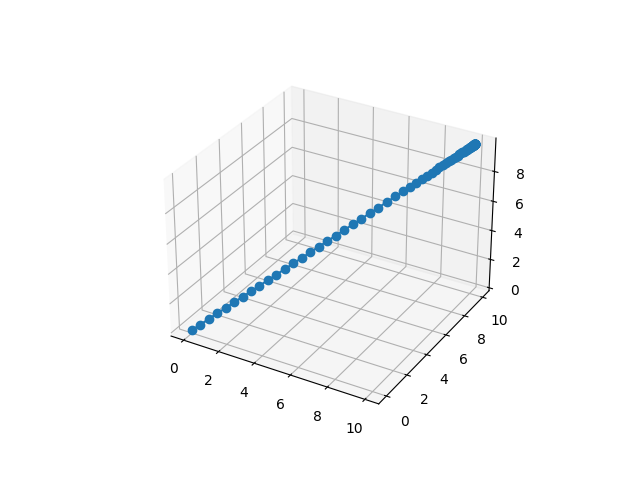

In [56]:
# Make a #=3D plot of the state X
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(X.value[:, 0], X.value[:, 1], X.value[:, 2], marker='o')
plt.grid()
plt.show()


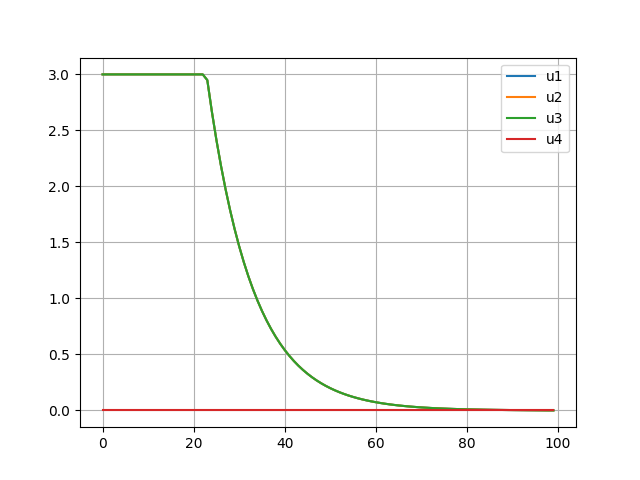

In [52]:
# Plot all input values separately
plt.figure()
plt.plot(U.value[:, 0], label='u1')
plt.plot(U.value[:, 1], label='u2')
plt.plot(U.value[:, 2], label='u3')
plt.plot(U.value[:, 3], label='u4')
plt.legend()
plt.grid()
plt.show()


In [23]:
# Enviornment variables
N = 100 # Number of states
n = 4 # Number of states
m = 1 # Length of input vector
dt = 0.1

# Define optimization variables
X = cp.Variable((N, n))
u = cp.Variable((N, m))

constraints = []
# Set constraints on u
constraints += [u <= 10]
constraints += [u >= -10]

# Weights for the cost function
w_s = 4
w_v = 8
w_a = 2 
w_j = 2
Q = np.eye(n) * np.transpose(np.array([w_s, w_v, w_a, w_j]))
w_u = 1
R = w_u

# Use the 4th order point mass-model
A = np.array([ [1,dt,(dt**2)/2,(dt**3)/6],
               [0,1,dt,(dt**2)/2],
               [0,0,1,dt],
               [0,0,0,1]])

B = np.array([ (dt**4)/24,
               (dt**3)/6,
               (dt**2)/2,
               dt]).reshape([n,])

## 3D Trajectory Generation with Obstacle avoidance

In [162]:
# Enviornment variables
N = 100 # Number of steps
n = 4 # Number of states
m = 4 # Length of input vector
dt = 0.1
v_max = 3

# Define the optimization variables
X = cp.Variable((N, n))
U = cp.Variable((N, m))

# Weights for the cost function
linear_weight = 1
weight_x = linear_weight
weight_y = linear_weight
weight_z = linear_weight
weight_w = 1
Q = np.eye(n) * np.transpose(np.array([weight_x, weight_y, weight_z, weight_w]))
R = np.eye(m)

# Define A & B matrices of point mass model
A = np.eye(n)
B = np.eye(n) * dt

In [163]:
X[1, 0:3]

Expression(AFFINE, UNKNOWN, (3,))

In [165]:
# Set the initial state
X_init = np.array([0, 0, 0, 0])

# Set the reference state
X_ref = np.array([10, 10, 10, 0])

constraints = []
# Set input constraints
constraints += [U <= v_max, U >= -v_max]

# Set the initial state constraint
constraints += [X[0] == X_init]

# Define the position of the obstacle
X_obs = np.array([5, 5, 5])
# safety_distance = np.array([1, 1, 1])
safety_distance = 2

# Add the obstacle constraint
# for t in range(N):
#     constraints += [(X[t, 0] - X_obs[0])**2 + (X[t, 1] - X_obs[1])**2 + (X[t, 2] - X_obs[2])**2 >= safety_distance**2]

for t in range(N):
    constraints += [cp.sum_squares(X[t, :3] - X_obs) >= safety_distance**2]

# Setup the optimization problem
states = []
cost = 0

# Define the cost function and model constraints
for t in range(N-1):
    # Define the cost function
    cost += cp.quad_form(X[t+1] - X_ref, Q) + cp.quad_form(U[t], R) 

    # Define the model constraints
    constraints += [X[t+1] == A @ X[t] + B @ U[t]]

# Define the optimization problem
problem = cp.Problem(cp.Minimize(cost), constraints)
problem.is_dcp()

# problem.solve()

False

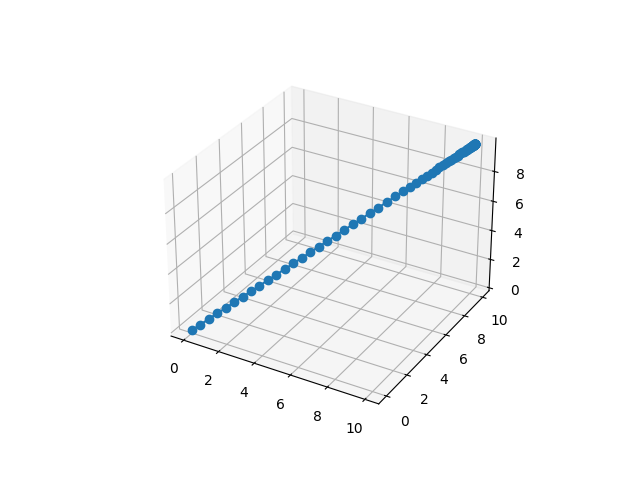

In [157]:
# Make a 3D plot of the state X
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(X.value[:, 0], X.value[:, 1], X.value[:, 2], marker='o')
plt.grid()
plt.show()

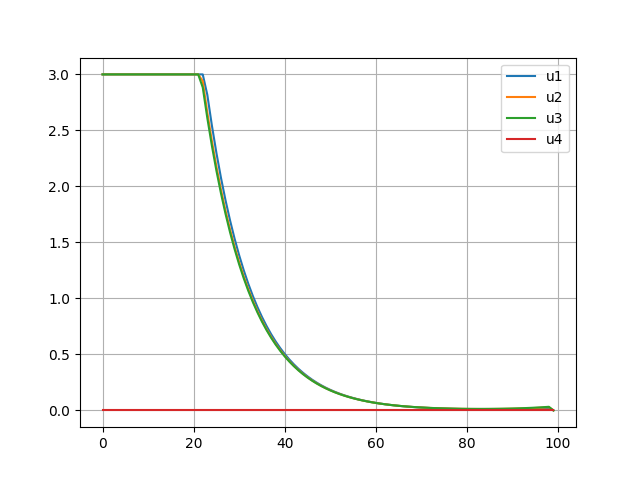

In [104]:
# Plot all input values separately
plt.figure()
plt.plot(U.value[:, 0], label='u1')
plt.plot(U.value[:, 1], label='u2')
plt.plot(U.value[:, 2], label='u3')
plt.plot(U.value[:, 3], label='u4')
plt.legend()
plt.grid()
plt.show()

In [161]:
import cvxpy as cp
import numpy as np

# Define the objects around AEV
# For example, let's consider 3 objects with their positions
# objects = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
objects = np.array([[1, 2, 3]])

# Define the AEV position
AEV_position = np.array([0, 0, 0])

# Define the dual norm
dual_norm = 2  # L2 norm

# Define the variables
lambda_var = cp.Variable(len(objects))

# Define the cost function
d = cp.norm(cp.vstack([cp.norm(AEV_position - obj, dual_norm) for obj in objects]))

# Define the constraints
constraints = [
    lambda_var >= 0,
    cp.sum(lambda_var) == 1
]

# Define the objective
objective = cp.Minimize(d)

# Define the problem
problem = cp.Problem(objective, constraints)

# Solve the problem
problem.solve()

# Get the optimal value of lambda
lambda_optimal = lambda_var.value

# Calculate the distance between AEV and objects
distance_AEV_objects = np.sum([lambda_optimal[i] * np.linalg.norm(AEV_position - objects[i]) for i in range(len(objects))])

print("Optimal value of lambda:", lambda_optimal)
print("Distance between AEV and objects:", distance_AEV_objects)


Optimal value of lambda: [1.00000002]
Distance between AEV and objects: 3.7416574733399064


## 1D Trajectory Generation
1D position tracking 

In [25]:
# Set the initial state
X_init = np.array([0,0,0,0])
# Set the reference velocity
v_ref = 5
x_ref = 10

# Setup optimization problem
states = []
cost = 0

# Set the initial state constraint
constraints += [X[0] == X_init]

# Define the model and constraints
for i in range(N-1):
    # Define the cost function
    cost += cp.quad_form(X[i] - np.array([x_ref, 0, 0, 0]), Q) + R*u[i]**2

    # Define the dynamics in the constraints
    constraints += [X[i+1] == A@X[i] + B*u[i]]

# Define the optimization problem
problem = cp.Problem(cp.Minimize(cost), constraints)
problem.is_dcp()

# Solve the problem
problem.solve()

12030.409112792206

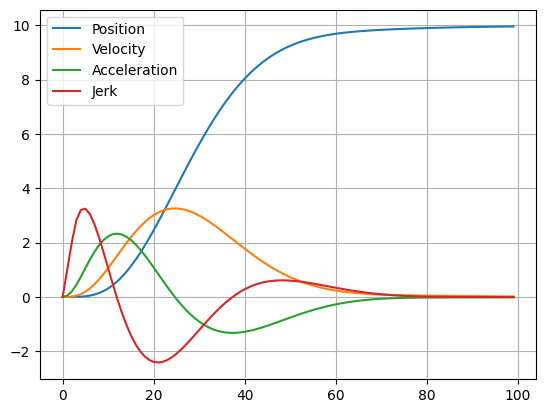

In [17]:
# Plot the results
import matplotlib.pyplot as plt

plt.figure()
plt.plot(X.value[:,0], label='Position')
plt.plot(X.value[:,1], label='Velocity')
plt.plot(X.value[:,2], label='Acceleration')
plt.plot(X.value[:,3], label='Jerk')
plt.legend()
plt.grid()
plt.show()

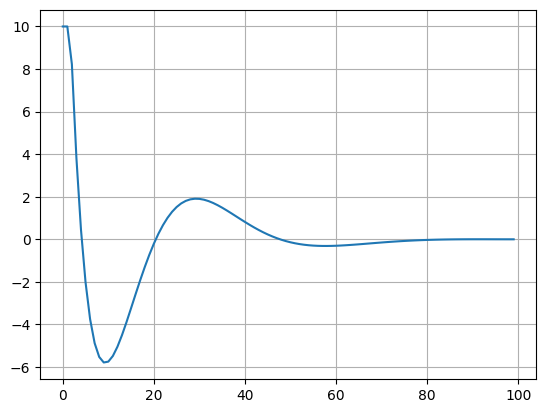

In [10]:
# Plot u
plt.figure()
plt.plot(u.value)
plt.grid()
plt.show()

# Trajectory Generation using gekko


Manipulated Variable (MV) means that GEKKO can change its value at every time step 


<br> https://transport-systems.imperial.ac.uk/tf/60008_21/n7_1_introduction_to_trajectory_optimisation.html

In [4]:
from gekko import GEKKO

## 1D Trajectory Generation

In [91]:
# Define initial conditions
xi = 0
vi = 0
xf = 10
vf = 0

# Set limits
v_max = 3
v_min = -3
a_max = 1
a_min = -1

In [99]:
# Define the model
m = GEKKO(remote=False)

# Define the time points
steps = 100
T = 10
m.time = np.linspace(0, T, steps)

# Define the state variables
x = m.Var(value=xi)
v = m.Var(value=vi, lb=v_min, ub=v_max)

# Define the control variable
a = m.MV(value=0, lb=a_min, ub=a_max)
a.STATUS = 1

# Since we created a time vector m.time between 0 and T, we need to create a scaling factor tf
# that documents the final time of the trajectory. Fixed Value (FV) means that the control variable will be fixed for all the vector m.time
tf_scheduled = m.FV(value=1, lb=0.1, ub=100)
tf_scheduled.STATUS = 1

# Define the differential equations
m.Equation(x.dt() == v*tf_scheduled)
m.Equation(v.dt() == a*tf_scheduled)

# Define the final conditions
m.fix(x, pos=len(m.time)-1, val=xf)
m.fix(v, pos=len(m.time)-1, val=vf)

# Define your scheduled time to reach the final conditions
tf = 1.0
A = 1.0 # Define the weight for the objective function

# Define the objective
m.Obj(A*(tf-tf_scheduled)**2)

# Solve the optimization problem
m.options.IMODE = 6
m.solve(disp=False)

# Print final travel time
print('Final Time: ' + str(tf_scheduled.value[0]))

Final Time: 1.0000008469


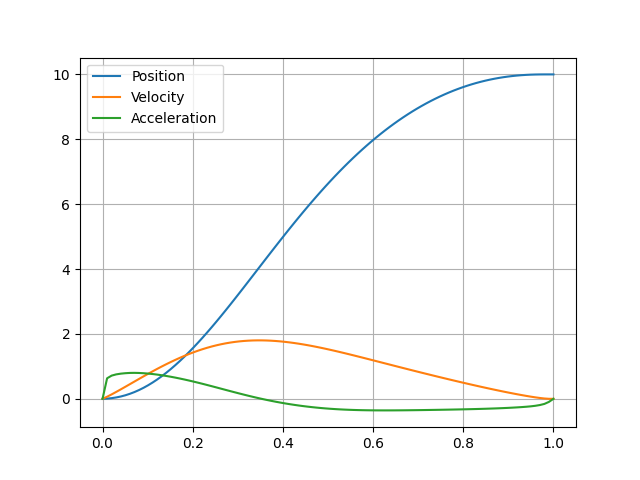

In [101]:
# Plot the results in a 15x15 grid
t = np.linspace(0, tf_scheduled[0], steps)
plt.figure()
plt.plot(t, x.value, label='Position')
plt.plot(t, v.value, label='Velocity')
plt.plot(t, a.value, label='Acceleration')
plt.legend()
plt.grid()
plt.show()


#### Imperial College Test

In [56]:
v_max   = 30     # maximum velocity
v_min   = -4     # minimum velocity
av_max  = 2      # maximum acceleration
av_min  = -2     # minimum acceleration (ie. maximum deceleration)
x_s     = 0      # starting position 
x_f     = 10     # ending position
v_bound = 0      # velocity in the start and end of the journey



In [57]:
m = GEKKO(remote=False) 

In [58]:
nt = 501
m.time = np.linspace(0,1,nt)

In [59]:
x = m.Var(value=0.0)
v = m.Var(value=0.0, lb=v_min, ub=v_max)

In [60]:
av = m.MV(value=0, lb=av_min,ub=av_max)
av.STATUS = 1

In [61]:
tf = m.FV(value=1.0,lb=0.1,ub=100.0)
tf.STATUS = 1

In [62]:
m.Equation(x.dt()==v*tf)
m.Equation(v.dt()==av*tf)

In [63]:
# path constraint
m.Equation(x >= 0)

# boundary constraints
m.fix(x, pos=len(m.time)-1,val=10.0) # vehicle must arrive at x=10
m.fix(v, pos=len(m.time)-1,val=0.0) # vehicle must come to a full stop

In [64]:
# objective - minimise the travel time
m.Obj(tf)

In [65]:
# solve
m.options.IMODE = 6
m.solve(disp=False)

# print final travel time
print('Final Time: ' + str(tf.value[0]))

Final Time: 4.4811073139


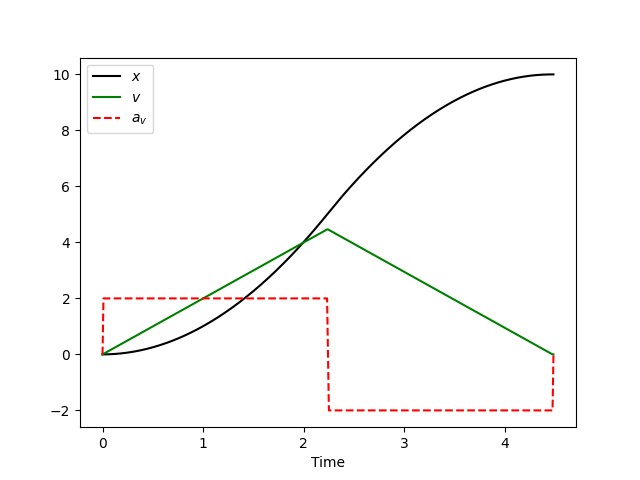

In [66]:
# plot solution
tm = np.linspace(0,tf.value[0],nt)
plt.figure()
plt.plot(tm,x.value,'k-',label=r'$x$')
plt.plot(tm,v.value,'g-',label=r'$v$')
plt.plot(tm,av.value,'r--',label=r'$a_v$')
plt.legend(loc='best')
plt.xlabel('Time')
plt.show()

## 3D Trajectory Generation

In [3]:
# Define the initial conditions
X0 = 0
Y0 = 0
Z0 = 0
vx0 = 0
vy0 = 0
vz0 = 0

# Define the final conditions
Xf = 10
Yf = 10
Zf = 10

# Set the limits
v_max = 3
v_min = -3
a_max = 1
a_min = -1

In [6]:
m = GEKKO(remote=False)

# Define the time points
steps = 100
T = 10
m.time = np.linspace(0, T, steps)

# Define the state variables
X = m.Var(value=X0)
Y = m.Var(value=Y0)
Z = m.Var(value=Z0)
vx = m.Var(value=vx0, lb=v_min, ub=v_max)
vy = m.Var(value=vy0, lb=v_min, ub=v_max)
vz = m.Var(value=vz0, lb=v_min, ub=v_max)

# Define the control variables
ax = m.MV(value=0, lb=a_min, ub=a_max)
ay = m.MV(value=0, lb=a_min, ub=a_max)
az = m.MV(value=0, lb=a_min, ub=a_max)
ax.STATUS = 1
ay.STATUS = 1
az.STATUS = 1

tf = m.FV(value=1, lb=0.1, ub=100)
tf.STATUS = 1

# Define the differential equations
m.Equation(X.dt() == vx*tf)
m.Equation(Y.dt() == vy*tf)
m.Equation(Z.dt() == vz*tf)

m.Equation(vx.dt() == ax*tf)
m.Equation(vy.dt() == ay*tf)
m.Equation(vz.dt() == az*tf)

# Define the final conditions
m.fix(X, pos=len(m.time)-1, val=Xf)
m.fix(Y, pos=len(m.time)-1, val=Yf)
m.fix(Z, pos=len(m.time)-1, val=Zf)

# Define your scheduled time to reach the final conditions
tf_scheduled = 1.0
A = 1.0 # Define the weight for prioritizing faster trajectories, maximizing the speed to reach final conditions

# Define the objective
m.Obj(A*(tf-tf_scheduled)**2)

# Solve the optimization problem
m.options.IMODE = 6
m.solve(disp=False)

# Print final travel time
print('Final Time: ' + str(tf.value[0]))

Final Time: 1.0000013478


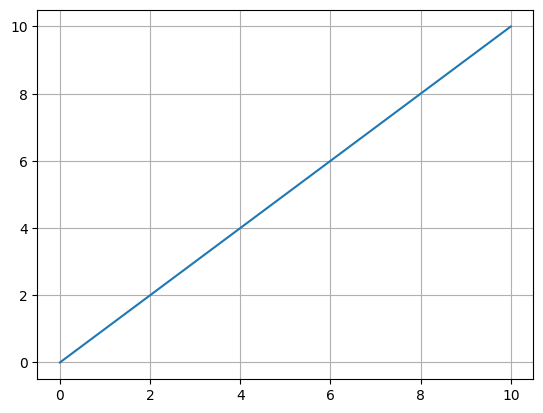

In [7]:
# Plot the results in a 3D grid
# t = np.linspace(0, tf[0], steps)
# plt.figure()
# plt.plot(t, X.value, label='X')
# plt.plot(t, Y.value, label='Y')
# plt.plot(t, Z.value, label='Z')
# plt.legend()
# plt.grid()
# plt.show()

# Plot the trajectory in 2D
plt.figure()
plt.plot(X.value, Y.value)
plt.grid()
plt.show()

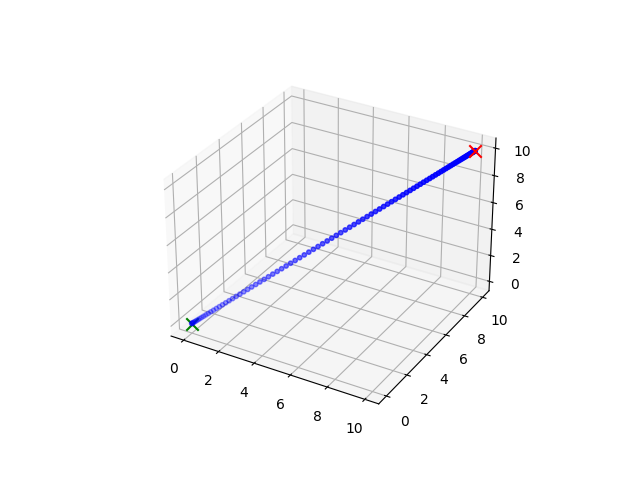

In [114]:
# Plot the X, Y, Z positions in a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X.value, Y.value, Z.value, color='b', marker='o', s=10)
# Plot the starting point
ax.scatter(X0, Y0, Z0, color='g', marker='x', s=80)
# Plot the ending point
ax.scatter(Xf, Yf, Zf, color='r', marker='x', s=80)
plt.grid()
plt.show()


 ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :           10
   Intermediates:            0
   Connections  :           12
   Equations    :            7
   Residuals    :            7
 
 Number of state variables:            232
 Number of total equations: -          216
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :             16
 
 ----------------------------------------------
 Dynamic Control with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  7.18122E+01  3.03774E+00
    1  3.88789E-02  3.96421E-01
    2  1.36860E+01  5.69773E-01
    3  2.24333E-01  1.07690E-01
    4  2.54901E-0

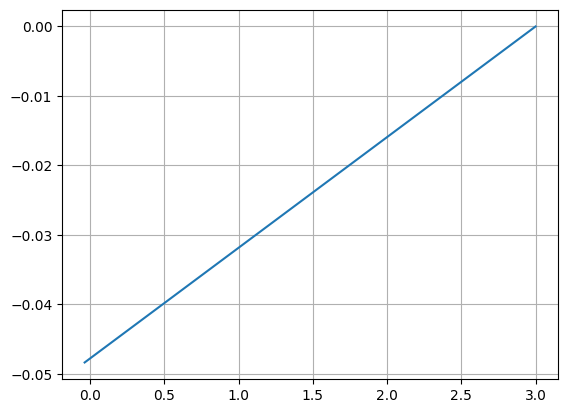

In [22]:
X0 = -0.037744149565696716
Y0 =  -0.048386599868535995
Z0 = -0.5426833629608154
vx0, vy0, vz0 = 0, 0, 0

Xf = 3
Yf = 0
Zf = -1

v_max, v_min = 3, -3
a_max, a_min = 1, -1

m = GEKKO(remote=False)

steps = min(int(((X0-Xf)**2 + (Y0-Yf)**2 + (Z0-Zf)**2)**0.5)+7, 15)
T = 10
m.time = np.linspace(0, T, steps)

X = m.Var(value=X0)
Y = m.Var(value=Y0)
Z = m.Var(value=Z0)
vx = m.Var(value=vx0, lb=v_min, ub=v_max)
vy = m.Var(value=vy0, lb=v_min, ub=v_max)
vz = m.Var(value=vz0, lb=v_min, ub=v_max)

# Define the control variables
ax = m.MV(value=0, lb=a_min, ub=a_max)
ay = m.MV(value=0, lb=a_min, ub=a_max)
az = m.MV(value=0, lb=a_min, ub=a_max)
ax.STATUS, ay.STATUS, az.STATUS = 1, 1, 1            

tf = m.FV(value=1, lb=0.1, ub=T)
tf.STATUS = 1

# Define the differential equations
m.Equation(X.dt() == vx*tf)
m.Equation(Y.dt() == vy*tf)
m.Equation(Z.dt() == vz*tf)

m.Equation(vx.dt() == ax*tf)
m.Equation(vy.dt() == ay*tf)
m.Equation(vz.dt() == az*tf)

# Define the final conditions
m.fix(X, pos=len(m.time)-1, val=Xf)
m.fix(Y, pos=len(m.time)-1, val=Yf)
m.fix(Z, pos=len(m.time)-1, val=Zf)
m.fix(vx, pos=len(m.time)-1, val=0)
m.fix(vy, pos=len(m.time)-1, val=0)
m.fix(vz, pos=len(m.time)-1, val=0)

# Calculate the distance between the initial and final points
distance = np.sqrt((Xf-X0)**2 + (Yf-Y0)**2 + (Zf-Z0)**2)
# Set the speed to reach the final point
velocity = 0.5

# Define your scheduled time to reach the final conditions
tf_scheduled = distance / velocity

A = 1.0 # Define the weight for prioritizing faster trajectories, maximizing the speed to reach final conditions

mayers_term = A*(tf-tf_scheduled)**2

cost = mayers_term #+ desired_position

# Define the objective
m.Obj(cost)

# Solve the optimization problem
m.options.IMODE = 6
m.options.SOLVER = 1
m.solve(disp=True)

# Print the minimum cost
print('Minimum Cost: ' + str(m.options.OBJFCNVAL))

# Print final travel time
print('Final Time: ' + str(tf.value[0]))

# Plot the X and Y positions in a 2D plot
plt.figure()
plt.plot(X.value, Y.value)
plt.grid()

In [11]:
X

[-0.08, 0.26222222222, 0.94666666667, 1.9733333333, 2.6577777778, 3.0, 3.0, 3.0]

In [12]:
Y

[-0.11, -0.097777777778, -0.073333333333, -0.036666666667, -0.012222222222, 0.0, 0.0, 0.0]

In [13]:
Z

[-0.28, -0.36, -0.52, -0.76, -0.92, -1.0, -1.0, -1.0]

## 3D Trajectory Tracking with Obstacle Avoidance

In [175]:
# Define the initial conditions
X0 = 0.041266437619924545
Y0 = -0.005541899241507053
Z0 = -0.5629867911338806
vx0 = 0
vy0 = 0
vz0 = 0

# 0.041266437619924545, -0.005541899241507053, -0.5629867911338806

# Define the final conditions
Xf = 3.0
Yf = 0.0
Zf = -1

# Set the limits
v_max = 1
v_min = -1
a_max = 1
a_min = -1

In [ ]:
# Define the initial conditions
X0 = 0.041266437619924545
Y0 = -0.005541899241507053
Z0 = -0.5629867911338806
vx0 = 0
vy0 = 0
vz0 = 0

# 0.041266437619924545, -0.005541899241507053, -0.5629867911338806

# Define the final conditions
Xf = 3.0
Yf = 0.0
Zf = -1

# Set the limits
v_max = 1
v_min = -1
a_max = 1
a_min = -1

m = GEKKO(remote=False)

# Define the time points
steps = 10
T = 5
m.time = np.linspace(0, T, steps)

# Define the state variables
X = m.Var(value=X0)
Y = m.Var(value=Y0)
Z = m.Var(value=Z0)
vx = m.Var(value=vx0, lb=v_min, ub=v_max)
vy = m.Var(value=vy0, lb=v_min, ub=v_max)
vz = m.Var(value=vz0, lb=v_min, ub=v_max)

# Define the control variables
ax = m.MV(value=0, lb=a_min, ub=a_max)
ay = m.MV(value=0, lb=a_min, ub=a_max)
az = m.MV(value=0, lb=a_min, ub=a_max)
ax.STATUS = 1
ay.STATUS = 1
az.STATUS = 1

tf = m.FV(value=1, lb=0.1, ub=T)
tf.STATUS = 1

# Define the differential equations
m.Equation(X.dt() == vx*tf)
m.Equation(Y.dt() == vy*tf)
m.Equation(Z.dt() == vz*tf)

m.Equation(vx.dt() == ax*tf)
m.Equation(vy.dt() == ay*tf)
m.Equation(vz.dt() == az*tf)

# Define the final conditions
m.fix(X, pos=len(m.time)-1, val=Xf)
m.fix(Y, pos=len(m.time)-1, val=Yf)
m.fix(Z, pos=len(m.time)-1, val=Zf)
m.fix(vx, pos=len(m.time)-1, val=0)
m.fix(vy, pos=len(m.time)-1, val=0)
m.fix(vz, pos=len(m.time)-1, val=0)
# m.fix(ax, pos=len(m.time)-1, val=0)
# m.fix(ay, pos=len(m.time)-1, val=0)
# m.fix(az, pos=len(m.time)-1, val=0)
# m.Minimize((X-Xf)**2 + (Y-Yf)**2 + (Z-Zf)**2)

# Define the position of an obstacle at (3, 3, 3)
# X_obs1, Y_obs1, Z_obs1 = 3, 3, 3
# X_obs1, Y_obs1, Z_obs1 = 7, 7, 7
# X_obs1, Y_obs1, Z_obs1 = 1.1, 1.1, 1.1
# Define the position of an obstacle at (7, 7, 7)
# X_obs2, Y_obs2, Z_obs2 = 5, 5, 5

# Define the obstacle at half the distance between the initial and final points
X_obs1, Y_obs1, Z_obs1 = (X0+Xf)/2, (Y0+Yf)/2, (Z0+Zf)/2

# Define the safety distance
safety_distance = 0.7

# Add the obstacle constraint
m.Equation((X - X_obs1)**2 + (Y - Y_obs1)**2 + (Z - Z_obs1)**2 >= safety_distance**2)
# m.Equation((X - X_obs2)**2 + (Y - Y_obs2)**2 + (Z - Z_obs2)**2 >= safety_distance**2)

# Calculate the distance between the initial and final points
distance = np.sqrt((Xf-X0)**2 + (Yf-Y0)**2 + (Zf-Z0)**2)

# Define your scheduled time to reach the final conditions
# Set the speed to reach the final point
velocity = 0.5
tf_scheduled = distance / velocity
A = 1.0 # Define the weight for prioritizing faster trajectories, maximizing the speed to reach final conditions

mayers_term = A*(tf-tf_scheduled)**2

desired_position = (X-Xf)**2 + (Y-Yf)**2 + (Z-Zf)**2

cost = mayers_term + desired_position

# Define the objective
m.Obj(cost)

# Solve the optimization problem
m.options.IMODE = 6
m.options.SOLVER = 3
m.solve(disp=False)

# Print the minimum cost
print('Minimum Cost: ' + str(m.options.OBJFCNVAL))

# Print final travel time
print('Final Time: ' + str(tf.value[0]))

In [ ]:
# Plot the x and y values in a 2D plot
plt.figure()
plt.scatter(X.value, Y.value)
plt.grid()
plt.show()

## Main working code

Initial Position:  -0.3536008827757431 -0.06012513585004653 -0.2629867911338806
Time:  6.868316353505673
Obstacle Position:  1.389515172555826 0.02699904686948145 -0.6062505631623312
Minimum Cost: 1170.939467
Number of Waypoints:  485


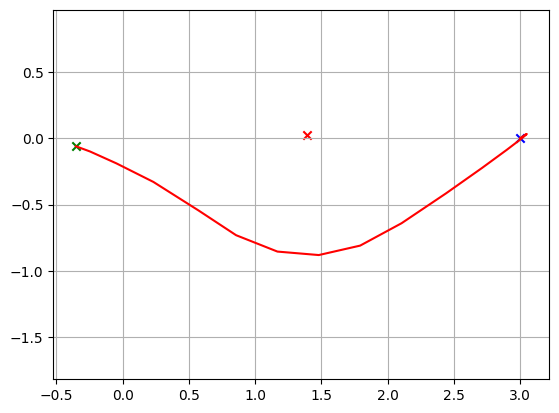

In [10]:
# Define the initial conditions
# generate random value between -0.5 and 0.5
X0 = np.random.rand() - 0.5
Y0 = np.random.rand() - 0.5
# Generate random z value between -0.1 and -0.6
Z0 = -0.2629867911338806
vx0 = 0
vy0 = 0
vz0 = 0

print("Initial Position: ", X0, Y0, Z0)

# 0.041266437619924545, -0.005541899241507053, -0.5629867911338806

# Define the final conditions
Xf = 3.0
Yf = 0.0
Zf = -1

# Xf = 10.0
# Yf = 0.0
# Zf = -1

# Set the limits
v_max = 1
v_min = -1
a_max = 1
a_min = -1

m = GEKKO(remote=False)

# steps = 50
steps = min(int(((X0-Xf)**2 + (Y0-Yf)**2 + (Z0-Zf)**2)**0.5)+20, 50) 

v_set = 0.5 # The velocity we'd like the drone to move at
# T = 5
T = ((X0-Xf)**2 + (Y0-Yf)**2 + (Z0-Zf)**2)**0.5 / v_set
print("Time: ", T)

m.time = np.linspace(0, T, steps)

# time = np.zeros(len(m.time))
# tf_scheduled = 3
# for i in range(len(m.time)):
#     if m.time[i] < tf_scheduled:
#         time[i] = 0
#     else:
#         time[i] = 1
# time = m.Param(value=time)

# Define the state variables
X = m.Var(value=X0)
Y = m.Var(value=Y0)
Z = m.Var(value=Z0)
vx = m.Var(value=vx0, lb=v_min, ub=v_max)
vy = m.Var(value=vy0, lb=v_min, ub=v_max)
vz = m.Var(value=vz0, lb=v_min, ub=v_max)

# Define the control variables
# ax = m.Var(lb=a_min, ub=a_max)gain
# ay = m.Var(lb=a_min, ub=a_max)
# az = m.Var(lb=a_min, ub=a_max)

ax = m.MV(value=0, lb=a_min, ub=a_max)
ay = m.MV(value=0, lb=a_min, ub=a_max)
az = m.MV(value=0, lb=a_min, ub=a_max)
ax.STATUS, ay.STATUS, az.STATUS = 1, 1, 1            


# Defining the Model
m.Equation(X.dt() == vx)
m.Equation(Y.dt() == vy)
m.Equation(Z.dt() == vz)
m.Equation(vx.dt() == ax)
m.Equation(vy.dt() == ay)
m.Equation(vz.dt() == az)

# Define the position of an obstacle at (3, 3, 3)
# X_obs1, Y_obs1, Z_obs1 = 3, 3, 3
# Define the position of an obstacle at (7, 7, 7)
# X_obs2, Y_obs2, Z_obs2 = 5, 5, 5
# X_obs2, Y_obs2, Z_obs2 = 7, 7, 7

# Define the obstacle at half the distance between the initial and final points
# Add a small random value to the obstacle position
X_obs1, Y_obs1, Z_obs1 = (X0+Xf)/2 + np.random.rand()*0.1, (Y0+Yf)/2 + np.random.rand()*0.1, (Z0+Zf)/2 + np.random.rand()*0.1
print("Obstacle Position: ", X_obs1, Y_obs1, Z_obs1)

# Define the safety distance
safety_distance = 1

# Add the obstacle constraint
m.Equation(((X - X_obs1)**2 + (Y - Y_obs1)**2 + (Z - Z_obs1)**2)**0.5 >= safety_distance)
# m.Equation((X - X_obs2)**2 + (Y - Y_obs2)**2 + (Z - Z_obs2)**2 >= safety_distance**2)

# Add the height constraint: z >= 0.5
# m.Equation(Z < -0.5)
# m.Equation(Z==Zf)

# Minimize the height difference
m.Obj(1e3*(Z - Zf)**2)

# Set the goal state
# m.fix(X, pos=len(m.time)-1, val=Xf)
# m.fix(Y, pos=len(m.time)-1, val=Yf)
# m.fix(Z, pos=len(m.time)-1, val=Zf)
# m.fix(vx, pos=len(m.time)-1, val=0)
# m.fix(vy, pos=len(m.time)-1, val=0)
# m.fix(vz, pos=len(m.time)-1, val=0)

# Minimize the final position
m.Obj(1e1*((X-Xf)**2 + (Y-Yf)**2 + (Z-Zf)**2))

gain = 1
# Define the objective
# m.Obj(gain*X**2)
# m.Obj(gain*Y**2)
# m.Obj(gain*Z**2)
m.Obj(ax**2 + ay**2 + az**2)
# m.Obj(m.time)

# Solve the optimization problem
m.options.SOLVER = 1
m.options.IMODE = 6
m.solve(disp=False)

# Print the minimum cost
print('Minimum Cost: ' + str(m.options.OBJFCNVAL))

def distance(point1, point2):
        return np.sqrt((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2 + (point1[2]-point2[2])**2)

# If the last point is not equal to the final point, replace it with the final point
if(X[-1], Y[-1], Z[-1]) != (Xf, Yf, Zf):
    X[-1], Y[-1], Z[-1] = Xf, Yf, Zf

# Given the X, Y, Z points, interpolate points between each point to get a smooth trajectory
waypoints = [(X[0], Y[0], Z[0])]

for i in range(len(X)-1):
    x = np.linspace(X[i], X[i+1], steps)[1:]
    y = np.linspace(Y[i], Y[i+1], steps)[1:]
    z = np.linspace(Z[i], Z[i+1], steps)[1:]

    # Append the waypoint only if it is not close to the previous waypoint
    # if distance((x[0], y[0], z[0]), waypoints[-1]) > 0.05:
    #     waypoints += [(x[j], y[j], z[j]) for j in range(len(x))]
    waypoints += [(x[j], y[j], z[j]) for j in range(len(x))]
print("Number of Waypoints: ", len(waypoints))
# print("Waypoints: ", waypoints)

# Add the final point to the waypoints if it is not already there
if waypoints[-1] != (Xf, Yf, Zf):
    waypoints += [(Xf, Yf, Zf)]

# Plot the x and y values in a 2D plot
plt.figure()
plt.plot([v[0] for v in waypoints], [v[1] for v in waypoints], 'r')
# Plot X, Y
# plt.scatter(X.value, Y.value)
# Plot the obstacle
plt.scatter(X_obs1, Y_obs1, color='r', marker='x')
# Plot the starting point
plt.scatter(X0, Y0, color='g', marker='x')
# Plot the ending point
plt.scatter(Xf, Yf, color='b', marker='x')
# Set the scale equally
plt.axis('equal')
plt.grid()
plt.show()

In [186]:
Z

[-0.26298679113, -0.36718993899, -0.57559623472, -0.87816453815, -1.1789246351, -1.3964666953, -1.5098056076, -1.5189413721, -1.4238739887, -1.2868338379, -1.162798777, -1.0724853936, -1.0171621591, -0.98943995676, -0.97987403803, -0.98027970581, -0.98487279957, -0.99022332721, -0.99471777379, -0.99789989018, -0.99994573515, -1.0012813988, -1.0023322823]

In [215]:
# Print the distance of each point waypoint from the obstacle
for i in range(len(waypoints)):
    if distance(waypoints[i], (X_obs1, Y_obs1, Z_obs1)) < safety_distance:
        print("Distance from obstacle: ", distance(waypoints[i], (X_obs1, Y_obs1, Z_obs1)))

Distance from obstacle:  0.9983003160508599
Distance from obstacle:  0.9967825929561459
Distance from obstacle:  0.995465231060602
Distance from obstacle:  0.9943490267092975
Distance from obstacle:  0.9934346579528749
Distance from obstacle:  0.992722682506647
Distance from obstacle:  0.9922135360603935
Distance from obstacle:  0.9919075309507311
Distance from obstacle:  0.9918048552054536
Distance from obstacle:  0.991905571966644
Distance from obstacle:  0.9922096192966828
Distance from obstacle:  0.9927168103685415
Distance from obstacle:  0.9934268340389958
Distance from obstacle:  0.9943392558006666
Distance from obstacle:  0.9954535191061074
Distance from obstacle:  0.9967689470545681
Distance from obstacle:  0.9982847444295845
Distance from obstacle:  0.9983832598241849
Distance from obstacle:  0.9969636939603378
Distance from obstacle:  0.9957421457287646
Distance from obstacle:  0.994719344646324
Distance from obstacle:  0.9938959042949649
Distance from obstacle:  0.993272320

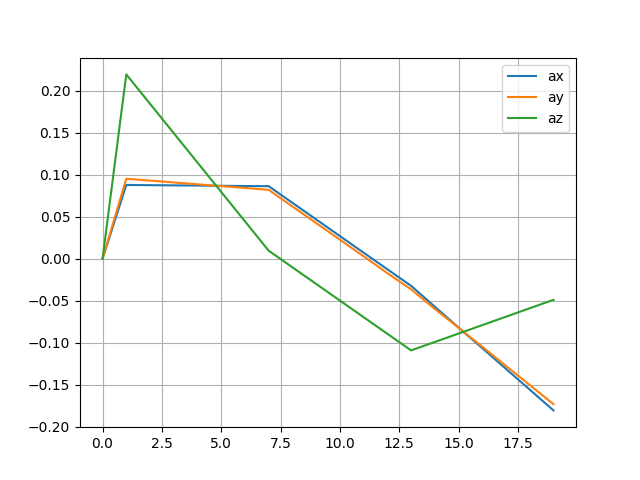

In [73]:
# Plot input values
plt.figure()
plt.plot(ax, label='ax')
plt.plot(ay, label='ay')
plt.plot(az, label='az')
plt.legend()
plt.grid()
plt.show()

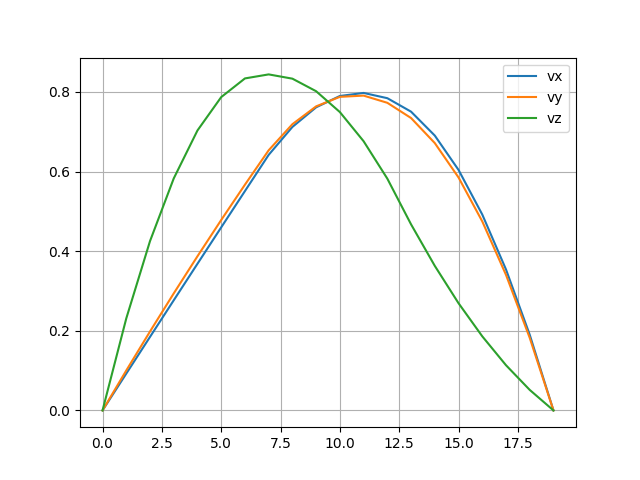

In [35]:
# Plot the velocities
plt.figure()
plt.plot(vx, label='vx')
plt.plot(vy, label='vy')
plt.plot(vz, label='vz')
plt.legend()
plt.grid()
plt.show()

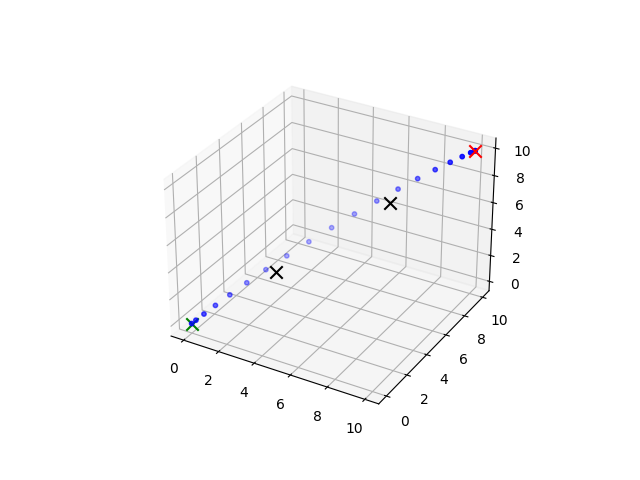

In [36]:
# Plot the X, Y, Z positions in a 3D plot
fig = plt.figure()
axes = fig.add_subplot(111, projection='3d')
axes.scatter(X, Y, Z, color='b', marker='o', s=10)
# Plot the starting point
axes.scatter(X0, Y0, Z0, color='g', marker='x', s=80)
# Plot the ending point
axes.scatter(Xf, Yf, Zf, color='r', marker='x', s=80)

# Plot the obstacle
axes.scatter(X_obs1, Y_obs1, Z_obs1, color='k', marker='x', s=80)
axes.scatter(X_obs2, Y_obs2, Z_obs2, color='k', marker='x', s=80)
plt.grid()
plt.show()


In [ ]:
import numpy as np
from gekko import GEKKO

m = GEKKO(remote=False)
nt = 50
m.time = np.linspace(0,1,nt)

# mark final time point
p = np.zeros(nt); p[-1] = 1 
final = m.Param(p)

# define theta as a Variable
#theta = m.Var(value=np.pi/2.0,lb=0,ub=2*np.pi)

# define theta as an MV
theta = m.MV(value=0,lb=0,ub=2*np.pi)
theta.STATUS = 1; theta.DCOST = 0

V = m.FV(value=2.15,lb=0,ub=10) # velocity
#V.STATUS = 1

x,y,dx,dy,ddx,ddy = m.Array(m.Var,6)

# Set the x, y, dx, dy, ddx, ddy initial conditions
x.value = 1.0
y.value = 0.25
dx.value = 0.0
dy.value = 0.0
ddx.value = 0.0
ddy.value = 0.0

m.Equation(x.dt()==V*m.cos(theta))
m.Equation(y.dt()==V*m.sin(theta))
m.Equation(((x-0.4)**2)+((y-0.5)**2)>=0.1)
m.Equation(((x-0.8)**2)+((y-1.5)**2)>=0.1)

m.Equation(dx==x.dt())
m.Equation(dy==y.dt())
m.Equation(ddx==dx.dt())
m.Equation(ddy==dy.dt())

# alternative 1 terminal constraint
m.Minimize(1e4*(x-1.2)**2)
m.Minimize(1e4*(y-1.6)**2)

# alternative 2 terminal constraint
#m.fix_final(x,1.2)
#m.fix_final(y,1.6)

# alternative 3 terminal constraint
#m.Equation((x-1.2)*final==0)
#m.Equation((y-1.6)*final==0)

# objective
m.Minimize(m.integral((ddx**2)+(ddy**2))*final)

m.options.SOLVER = 3
m.options.MAX_ITER = 1000
m.options.NODES = 3
m.options.IMODE = 6 # optimal control mode
m.solve(disp=False)

import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
th = np.linspace(0,2*np.pi,500)
x1 = np.sqrt(0.1)*np.cos(th)+0.4
y1 = np.sqrt(0.1)*np.sin(th)+0.5
x2 = np.sqrt(0.1)*np.cos(th)+0.8
y2 = np.sqrt(0.1)*np.sin(th)+1.5
plt.plot(x1,y1,'r',x2,y2,'r');
plt.plot(x.value,y.value,'b-o',markersize=2)
plt.plot([1.2],[1.6],'o',color='orange')
plt.xlabel('x'); plt.xlim([0,2.0])
plt.ylabel('y'); plt.ylim([0,2.0])
plt.title('Obstacle avoidance state variables, Speed = %2.4g'%V.value[0])